In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 99% 119M/121M [00:06<00:00, 22.3MB/s]
100% 121M/121M [00:06<00:00, 18.8MB/s]


In [ ]:
!unzip face-expression-recognition-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating:

In [ ]:
!pip install facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.4 MB/s eta 0:00:00


In [ ]:
from facenet_pytorch import InceptionResnetV1
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import torchvision
import torch.nn.functional as F

In [ ]:
class Image_Dataset(Dataset):
    def __init__(self, train=True):
        self.train = train
        
        if self.train:
            self.transform = transforms.Compose([
                transforms.Resize(160),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(160),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        
        # Load the data from the appropriate directories
        if self.train:
            self.data = load_train_data()
        else:
            self.data = load_val_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path, label = self.data[index]
        image = Image.open(image_path)
  
        image = self.transform(image.convert('RGB'))
        return image, label

In [ ]:
labels = ['sad', 'disgust', 'neutral', 'happy', 'surprise', 'angry', 'fear']
def load_train_data():
    file_path = 'images/train'
    data = []
    folders = os.listdir(file_path)
    for folder in folders:
        files = os.listdir(file_path+'/'+folder)
        for file in files:
            f_path = os.path.join(file_path, folder, file)          
            label_one_hot = np.zeros(len(labels))
            label_one_hot[labels.index(folder)] = 1
            data.append((f_path, label_one_hot))
    return data


def load_val_data():
    data = []
    file_path = 'images/validation'
    folders = os.listdir(file_path)
    for folder in folders:
        files = os.listdir(file_path+'/'+folder)
        for file in files:
            f_path = os.path.join(file_path, folder, file)  
            label_one_hot = np.zeros(len(labels))
            label_one_hot[labels.index(folder)] = 1
            data.append((f_path, label_one_hot))
    return data


In [ ]:
# List of available labels
labels = ['sad', 'disgust', 'neutral', 'happy', 'surprise', 'angry', 'fear']
# Example one-hot encoding vector
one_hot_vector = np.array([0, 1, 0, 0,0,0,0])

# Convert one-hot encoding to label index
label_index = np.argmax(one_hot_vector)

# Retrieve label from the labels list
label = labels[label_index]

print("Original one-hot encoding vector:", one_hot_vector)
print("Label index:", label_index)
print("Label:", label)

Original one-hot encoding vector: [0 1 0 0 0 0 0]
Label index: 1
Label: disgust


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train_data = Image_Dataset()
val_data = Image_Dataset(train=False)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=100, shuffle=True)
dataloaders ={'train': train_loader, 'val': val_loader}

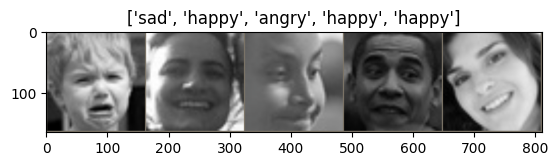

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
label_index = np.argmax(classes)
label = labels[label_index]
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[labels[np.argmax(x)] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.argmax(dim=1))
                    _, preds = torch.max(outputs, dim=1)
                    _, labels = torch.max(labels, dim=1)

                    # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                # statistics                          
                running_loss += loss.item() * inputs.size(0)
               
                running_corrects += torch.sum(preds == labels.data)
                


            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects.double() / len(dataloaders[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
class MyModel(InceptionResnetV1):
    def __init__(self, pretrained='vggface2'):
        super(MyModel, self).__init__(pretrained=pretrained)
        
        # Replace the last fully connected layer with a new nn.Linear layer
        num_ftrs = self.logits.in_features
        self.logits = nn.Linear(num_ftrs, 7)
        
    def forward(self, x):
        # Call the forward pass of the original model
        x = super(MyModel, self).forward(x)
          
        # Call the forward pass of the last fully connected layer
        x = self.logits(x)
        #x = nn.functional.softmax(x, dim=1)
        return x
model = MyModel()
# Move the model to the desired device (e.g., GPU or CPU)
model = model.to(device)

# Specify the criterion (loss function) and optimizer
criterion = nn.CrossEntropyLoss()
params_to_update = [p for p in model.parameters() if p.requires_grad]

# Specify the optimizer to only optimize the parameters of the logits layer
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9, weight_decay=1e-5)

In [ ]:
model_ft = train_model(model, criterion, optimizer,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 190.0661 Acc: 23.2837
val Loss: 184.9816 Acc: 26.2254
Epoch 1/19
----------
train Loss: 179.6944 Acc: 28.7543
val Loss: 171.7327 Acc: 37.2958
Epoch 2/19
----------
train Loss: 165.2915 Acc: 42.5571
val Loss: 156.2254 Acc: 49.6338
Epoch 3/19
----------
train Loss: 150.8420 Acc: 53.5709
val Loss: 142.9872 Acc: 56.3099
Epoch 4/19
----------
train Loss: 138.8315 Acc: 58.5363
val Loss: 132.9756 Acc: 59.6197
Epoch 5/19
----------
train Loss: 128.8642 Acc: 61.8166
val Loss: 125.1644 Acc: 61.3803
Epoch 6/19
----------
train Loss: 120.3165 Acc: 64.8339
val Loss: 118.7550 Acc: 63.5070
Epoch 7/19
----------
train Loss: 112.5978 Acc: 67.0761
val Loss: 114.5202 Acc: 64.2254
Epoch 8/19
----------
train Loss: 105.7156 Acc: 69.5156
val Loss: 111.7592 Acc: 63.9718
Epoch 9/19
----------
train Loss: 99.0521 Acc: 71.7785
val Loss: 107.8598 Acc: 64.5493
Epoch 10/19
----------
train Loss: 93.2008 Acc: 73.6990
val Loss: 105.2627 Acc: 65.3944
Epoch 11/19
----------
train Loss

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model_ft.state_dict(), '/content/drive/My Drive/face_regconition/emotion.pt')


In [ ]:
state_dict = torch.load('/content/drive/My Drive/face_regconition/emotion.pt')


In [ ]:
model.load_state_dict(state_dict)


<All keys matched successfully>

In [ ]:
import cv2


In [ ]:
class MyModel(InceptionResnetV1):
    def __init__(self, pretrained='vggface2'):
        super(MyModel, self).__init__(pretrained=pretrained)
        
        # Replace the last fully connected layer with a new nn.Linear layer
        num_ftrs = self.logits.in_features
        self.logits = nn.Linear(num_ftrs, 7)
        
    def forward(self, x):
        # Call the forward pass of the original model
        x = super(MyModel, self).forward(x)
          
        # Call the forward pass of the last fully connected layer
        x = self.logits(x)
        x = nn.functional.softmax(x, dim=1)
        return x
model = MyModel()

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load and preprocess an input image for prediction
image_path = '/content/drive/My Drive/face_regconition/face_image/hung_5.jpg'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.12, minNeighbors=6, minSize=(200, 200))
normalize = transforms.Compose([
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
model.eval()
# Loop through detected faces and make predictions
for (x, y, w, h) in faces:
      face = image[y:y + h, x:x + w]
      face = cv2.resize(face, (160, 160))  # Resize face to match input size of the model
      face = torch.from_numpy(face).permute(2, 0, 1).unsqueeze(0).float()  # Convert face to torch tensor
      face = face / 255.0
      face = normalize(face)
      with torch.no_grad():
          outputs = model(face)  # Pass face through the model
      predictions = torch.argmax(outputs, dim=1)  # Get the predicted class label
      label = labels[predictions]

In [ ]:
label

'sad'